Código Completo

Episode: 0, Total Reward: -22372


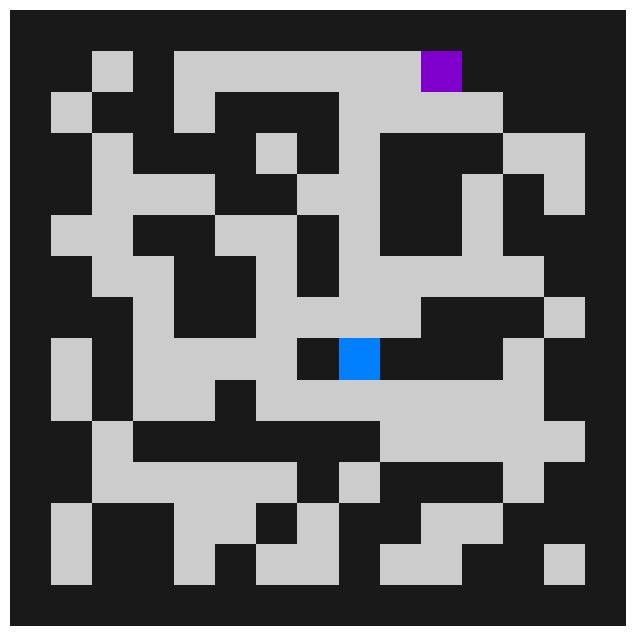

Episode: 100, Total Reward: -6493


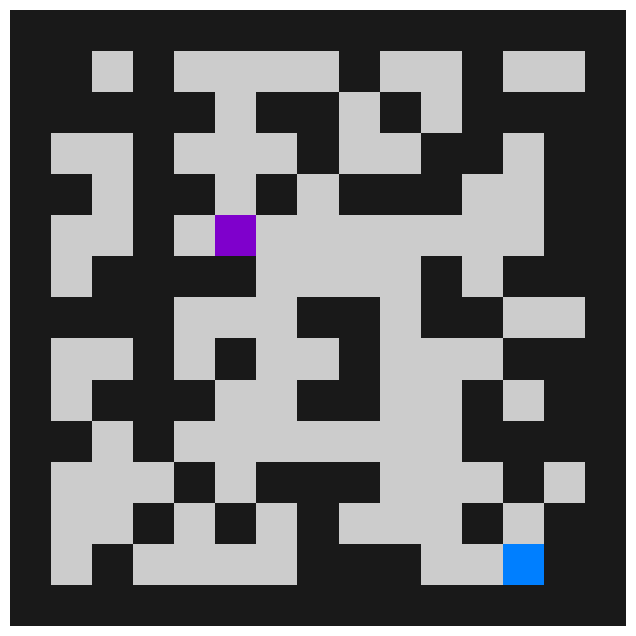

Episode: 200, Total Reward: -9494


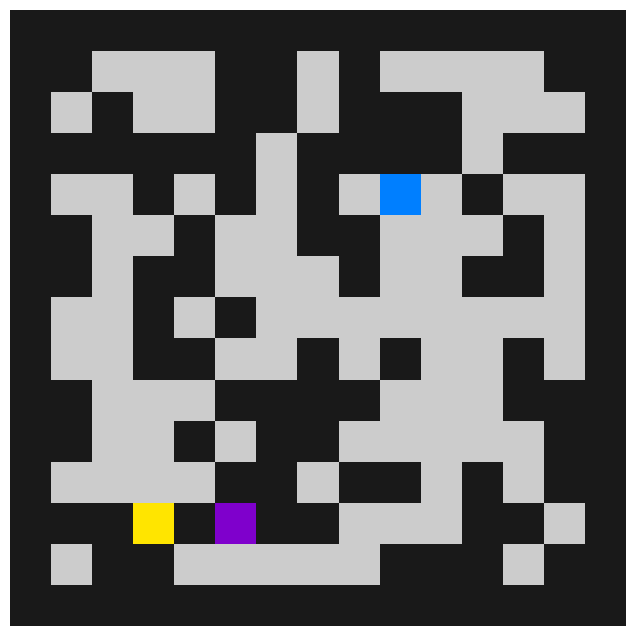

Episode: 300, Total Reward: -6956


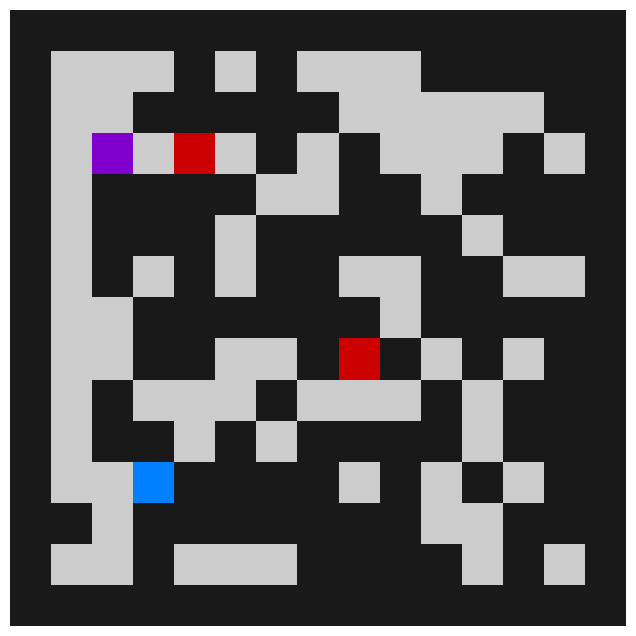

Episode: 400, Total Reward: -4979


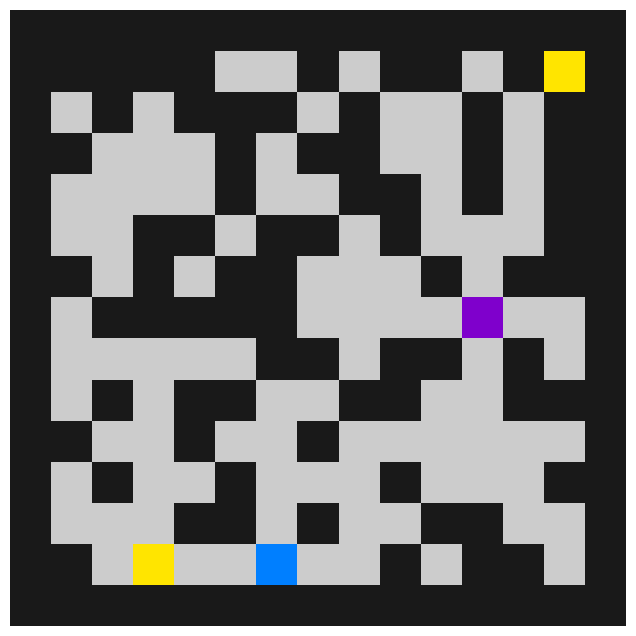

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import gym
from gym import spaces
from collections import deque

class DungeonBuilderEnv(gym.Env):
    def __init__(self, size=15, num_treasures=3, num_enemies=3):
        super(DungeonBuilderEnv, self).__init__()
        self.size = size
        self.num_treasures = num_treasures
        self.num_enemies = num_enemies
        self.state = np.zeros((size, size), dtype=int)
        self.current_position = (random.randint(1, size-2), random.randint(1, size-2))
        self.entry_placed = self.exit_placed = False
        self.placed_treasures = self.placed_enemies = 0

        self.colors = {
            0: [0.1, 0.1, 0.1],   # Parede (preto)
            1: [0.8, 0.8, 0.8],   # Caminho (branco)
            2: [0, 0.5, 1],       # Entrada (azul)
            3: [0.5, 0, 0.8],     # Fim (roxo)
            4: [1, 0.9, 0],       # Tesouro (amarelo)
            5: [0.8, 0, 0]        # Inimigo (vermelho)
        }

        self.action_space = spaces.Discrete(4)  # 4 ações: criar caminho, criar parede, colocar tesouro, colocar inimigo
        self.observation_space = spaces.Box(low=0, high=5, shape=(size, size), dtype=np.int32)

    def step(self, action):
        x, y = self.current_position
        reward = -1  # Penalidade padrão
        done = False

        # Executando a ação
        if action == 0:  # Criar caminho
            if self.state[x, y] not in [2, 3]:  # Não pode substituir entrada ou saída
                self.state[x, y] = 1
                reward = 3
        elif action == 1:  # Criar parede
            if self.state[x, y] not in [2, 3]:  # Não pode substituir entrada ou saída
                self.state[x, y] = 0
        elif action == 2 and self.placed_treasures < self.num_treasures:  # Colocar tesouro
            if self.state[x, y] == 1:  # Só pode colocar tesouro em um caminho
                self.state[x, y] = 4
                self.placed_treasures += 1
                reward = 10
        elif action == 3 and self.placed_enemies < self.num_enemies:  # Colocar inimigo
            if self.state[x, y] == 1:  # Só pode colocar inimigo em um caminho
                self.state[x, y] = 5
                self.placed_enemies += 1
                reward = 5

        # Penalidades e recompensas
        reward += self.calculate_map_score()

        # Movendo o agente para uma posição válida (ele pode mover para qualquer célula)
        self.current_position = self.move_agent(x, y)

        # Verificar se o episódio terminou
        if self.placed_treasures == self.num_treasures and self.placed_enemies == self.num_enemies and self.entry_placed and self.exit_placed and self.is_connected():
            done = True

        return self.state.copy(), reward, done, {}

    def calculate_map_score(self):
      reward = 0

      # Recompensa se o mapa estiver conectado
      if self.is_connected():
          reward += 50
      else:
          reward -= 10

      # Penaliza tesouros adjacentes
      if self.are_treasures_adjacent():
          reward -= 10

      # Recompensa tesouros distantes
      if self.are_treasures_distant():
          reward += 8

      # Recompensa inimigos perto de tesouros
      if self.are_enemies_near_treasures():
          reward += 8

      # Penaliza mapas sem tesouros ou inimigos
      if self.placed_treasures == 0 and self.placed_enemies == 0:
          reward -= 50

      # Recompensa extra: tesouros e inimigos nos caminhos conectados
      reward += self.reward_for_connected_path()

      return reward

    def reward_for_connected_path(self):
      """Calcula a recompensa extra para tesouros e inimigos nos caminhos conectados."""
      reward = 0

      if not self.entry_placed or not self.exit_placed:
          return reward  # Retorna 0 se a entrada ou saída não estiverem colocadas

      start = np.argwhere(self.state == 2)  # Encontra a entrada
      end = np.argwhere(self.state == 3)  # Encontra a saída

      if len(start) == 0 or len(end) == 0:
          return reward

      start = tuple(start[0])

      # Encontre o caminho entre a entrada e a saída
      queue = deque([start])
      visited = set()
      path_cells = set()

      while queue:
          x, y = queue.popleft()
          visited.add((x, y))
          path_cells.add((x, y))

          if self.state[x, y] == 3:  # Se encontrou a saída
              break

          # Checando células vizinhas (caminho ou saída)
          for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
              nx, ny = x + dx, y + dy
              if (1 <= nx < self.size-1 and 1 <= ny < self.size-1 and
                      (nx, ny) not in visited and self.state[nx, ny] in [1, 3]):
                  queue.append((nx, ny))

      # Agora verificamos quantos tesouros e inimigos estão nos caminhos conectados
      treasures_in_path = 0
      enemies_in_path = 0
      for (x, y) in path_cells:
          if self.state[x, y] == 4:  # Tesouro
              treasures_in_path += 1
          elif self.state[x, y] == 5:  # Inimigo
              enemies_in_path += 1

      # Recompensa extra para tesouros e inimigos no caminho
      reward += treasures_in_path * 5 + enemies_in_path * 3  # Pode ajustar os multiplicadores conforme necessário

      return reward


    def is_connected(self):
        """Verifica se há um caminho de células do tipo 'caminho' da entrada até a saída."""
        if not self.entry_placed or not self.exit_placed:
            return False

        start = np.argwhere(self.state == 2)  # Encontra a entrada
        end = np.argwhere(self.state == 3)  # Encontra a saída

        if len(start) == 0 or len(end) == 0:
            return False

        start = tuple(start[0])

        queue = deque([start])
        visited = set()

        while queue:
            x, y = queue.popleft()
            visited.add((x, y))

            if self.state[x, y] == 3:  # Se encontrou a saída
                return True

            # Checando células vizinhas (caminho ou saída)
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if (1 <= nx < self.size-1 and 1 <= ny < self.size-1 and
                        (nx, ny) not in visited and self.state[nx, ny] in [1, 3]):
                    queue.append((nx, ny))

        return False

    def are_treasures_adjacent(self):
        """Verifica se há tesouros adjacentes"""
        treasures = np.argwhere(self.state == 4)
        for (x1, y1) in treasures:
            for (x2, y2) in treasures:
                if (x1, y1) != (x2, y2) and abs(x1 - x2) <= 1 and abs(y1 - y2) <= 1:
                    return True
        return False

    def are_treasures_distant(self):
        """Verifica se os tesouros estão distantes uns dos outros"""
        treasures = np.argwhere(self.state == 4)
        for i in range(len(treasures)):
            for j in range(i + 1, len(treasures)):
                dist = np.linalg.norm(treasures[i] - treasures[j])
                if dist > 5:  # Distância mínima de 5 unidades
                    return True
        return False

    def are_enemies_near_treasures(self):
        """Verifica se há inimigos próximos de tesouros"""
        treasures = np.argwhere(self.state == 4)
        enemies = np.argwhere(self.state == 5)
        for t in treasures:
            for e in enemies:
                if np.linalg.norm(t - e) <= 2:  # Distância máxima de 2 unidades
                    return True
        return False

    def move_agent(self, x, y):
        """Move o agente para uma posição aleatória no mapa, permitindo passar por paredes."""
        # O agente pode mover para qualquer célula do mapa (mesmo que seja uma parede ou caminho)
        return (random.randint(1, self.size-2), random.randint(1, self.size-2))

    def reset(self):
        self.state.fill(0)

        self.placed_treasures = self.placed_enemies = 0
        self.entry_placed = self.exit_placed = False

        # Colocar a entrada e a saída no início de cada episódio
        entry_x, entry_y = random.randint(1, self.size-2), random.randint(1, self.size-2)
        exit_x, exit_y = random.randint(1, self.size-2), random.randint(1, self.size-2)

        self.state[entry_x, entry_y] = 2  # Coloca a entrada
        self.state[exit_x, exit_y] = 3    # Coloca a saída
        self.entry_placed = self.exit_placed = True
        self.current_position = entry_x, entry_y

        return self.state.copy()

    def render(self):
        cmap = ListedColormap([self.colors[i] for i in range(6)])
        plt.figure(figsize=(8, 8))
        plt.imshow(self.state, cmap=cmap, vmin=0, vmax=5)
        plt.axis('off')
        plt.show()

# Parâmetros do Q-learning
alpha = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 1000

# Criando o ambiente
env = DungeonBuilderEnv(size=15, num_treasures=3, num_enemies=3)

# Inicializando a Tabela Q
q_table = np.zeros((env.size, env.size, env.action_space.n))

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    counter = 0
    while not done:
        x, y = env.current_position
        action = env.action_space.sample() if random.uniform(0, 1) < epsilon else np.argmax(q_table[x, y])
        next_state, reward, done, _ = env.step(action)
        next_x, next_y = env.current_position
        # Atualizando a Tabela Q
        q_table[x, y, action] = (1 - alpha) * q_table[x, y, action] + alpha * (reward + gamma * np.max(q_table[next_x, next_y]))
        total_reward += reward
        counter += 1
        if counter == 10000:
            break

    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    if episode % 100 == 0:
        print(f"Episode: {episode}, Total Reward: {total_reward}")
        env.render()

env.render()
